In [56]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from tensorflow.random import set_seed 
from keras.layers import Input, Dropout,Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import pyod

In [57]:
#Import data from google drive
data = pd.read_csv('/Users/yaominglu/Documents/Anomaly detection/BearingVibration_Dataset.csv')

#Cek Data Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  982 non-null    object 
 1   Bearing 1   982 non-null    float64
 2   Bearing 2   982 non-null    float64
 3   Bearing 3   982 non-null    float64
 4   Bearing 4   982 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.5+ KB


In [58]:
#Convert Unnamed column to datetime format
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'], format = '%Y-%m-%d %H:%M:%S')

#Rename Unnamed column 
data = data.rename(columns = {'Unnamed: 0':'Date'})

#Set Date column to index
data = data.set_index('Date')

print(data)

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
Date                                                           
2004-02-12 10:52:39   0.060236   0.074227   0.083926   0.044443
2004-02-12 11:02:39   0.061455   0.073844   0.084457   0.045081
2004-02-12 11:12:39   0.061361   0.075609   0.082837   0.045118
2004-02-12 11:22:39   0.061665   0.073279   0.084879   0.044172
2004-02-12 11:32:39   0.061944   0.074593   0.082626   0.044659
...                        ...        ...        ...        ...
2004-02-19 05:42:39   0.453335   0.161016   0.137440   0.119047
2004-02-19 05:52:39   0.337583   0.132400   0.144992   0.092125
2004-02-19 06:02:39   0.351111   0.152266   0.151299   0.100817
2004-02-19 06:12:39   0.001857   0.003732   0.003656   0.001786
2004-02-19 06:22:39   0.001168   0.000767   0.000716   0.001699

[982 rows x 4 columns]


[Text(0.5, 0, 'Year-Month-Date'), Text(0, 0.5, 'Vibration/Acceleration(g)')]

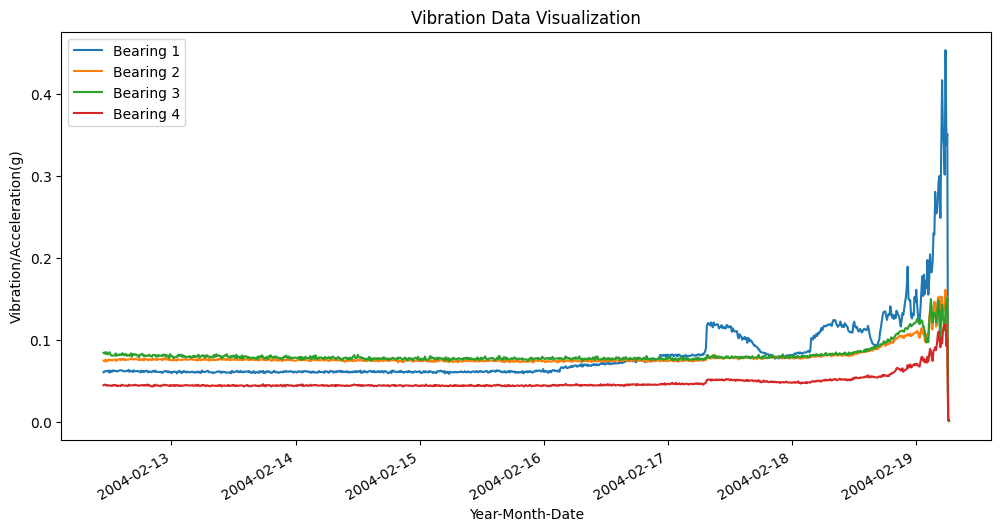

In [59]:
# Visualising Data
ax = data.plot(figsize = (12,6), title="Vibration Data Visualization" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")

In [60]:
 #Define training and testing data

train_data = data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test_data = data['2004-02-15 12:52:39':]
print("Training dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


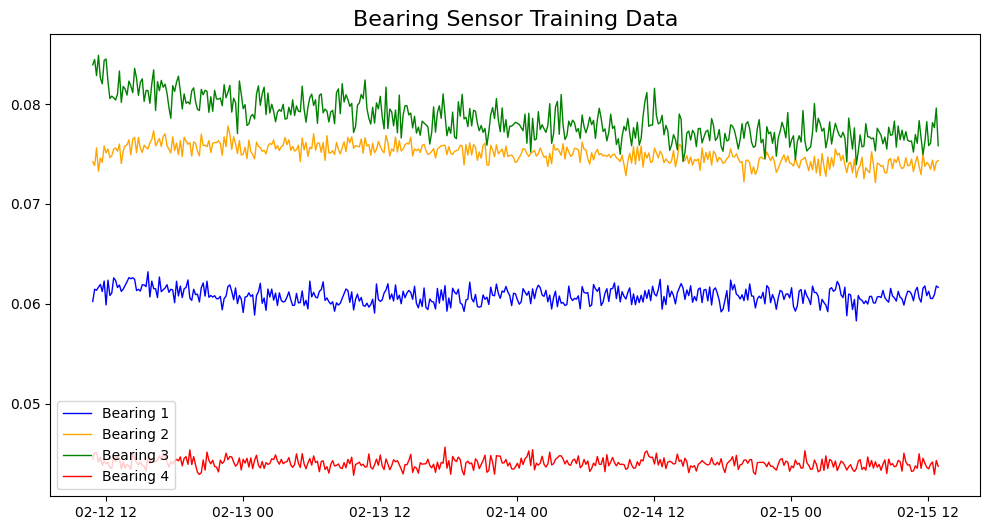

In [61]:
#Exploratory Data Analysis
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_data['Bearing 2'], label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(train_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_data['Bearing 4'], label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()
     

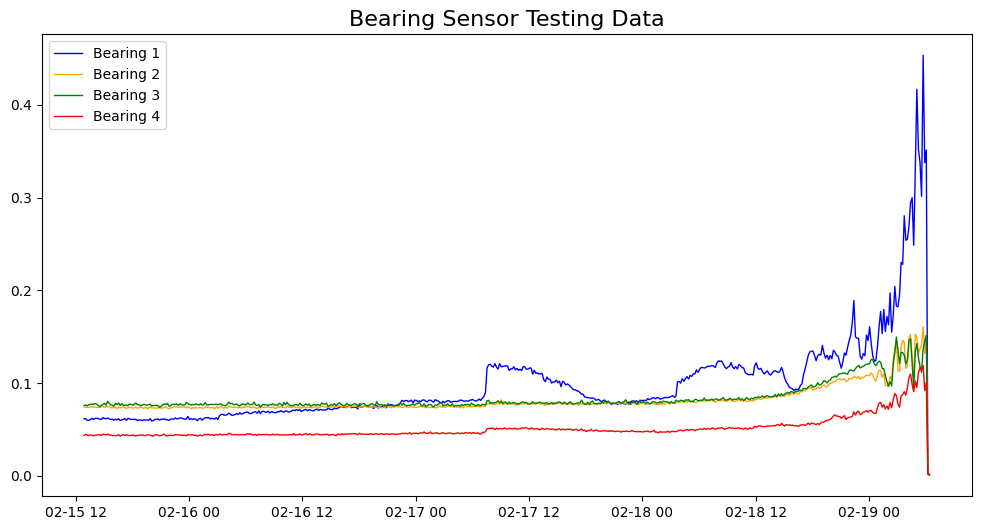

In [62]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_data['Bearing 2'], label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(test_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_data['Bearing 4'], label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='upper left')
ax.set_title('Bearing Sensor Testing Data', fontsize=16)
plt.show()

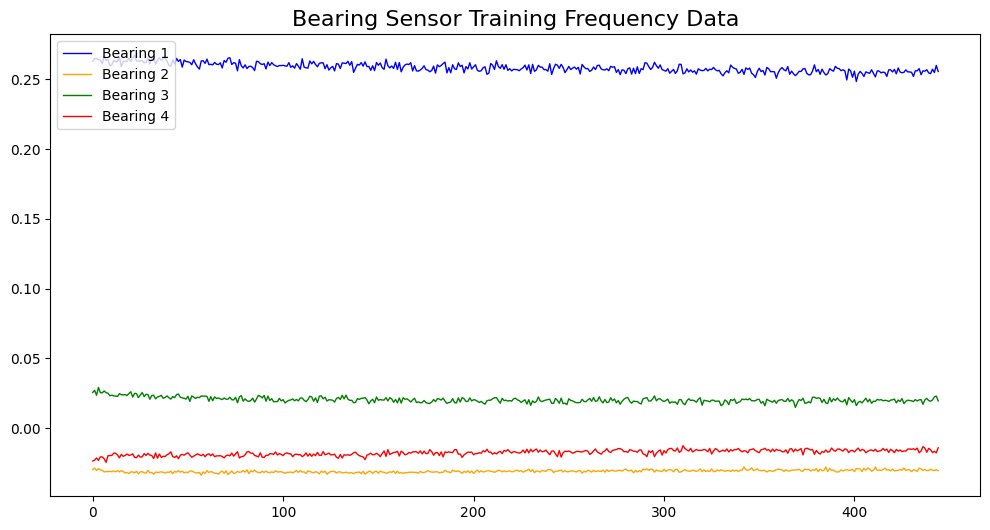

In [63]:
#transforming data to the frequency domain
#np.fft.fft 将时域数据转换为频域数据。
train_fft = np.fft.fft(train_data)
test_fft = np.fft.fft(test_data)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='upper left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

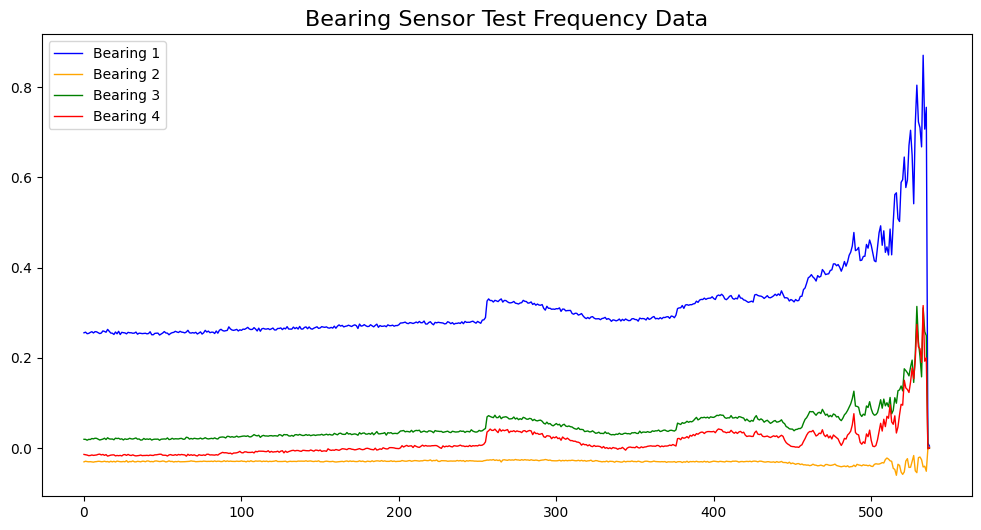

In [64]:
# Bearing Sensor Test Frequency Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='upper left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [82]:
#MODEL
#Pre-process
#Normalize data
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)
print("Number of features after scaling in training data:", X_train.shape[1])
print("Number of features after scaling in test data:", X_test.shape[1])

Number of features after scaling in training data: 4
Number of features after scaling in test data: 4


In [95]:

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [96]:

# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, return_sequences=True)(L3)
    L5 = LSTM(16, return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [97]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 4)           │            68 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236 (12.64 KB)

 Trainable params: 3,236 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# fit model
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4594 - val_loss: 0.2936
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3510 - val_loss: 0.1737
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2157 - val_loss: 0.1355
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 - val_loss: 0.1341
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1213 - val_loss: 0.1344
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1151 - val_loss: 0.1285
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1140 - val_loss: 0.1254
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1093 - val_loss: 0.1223
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1050 - val_loss: 0.1180
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1025 - val_loss: 0.1190
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0979 - val_loss: 0.1143
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

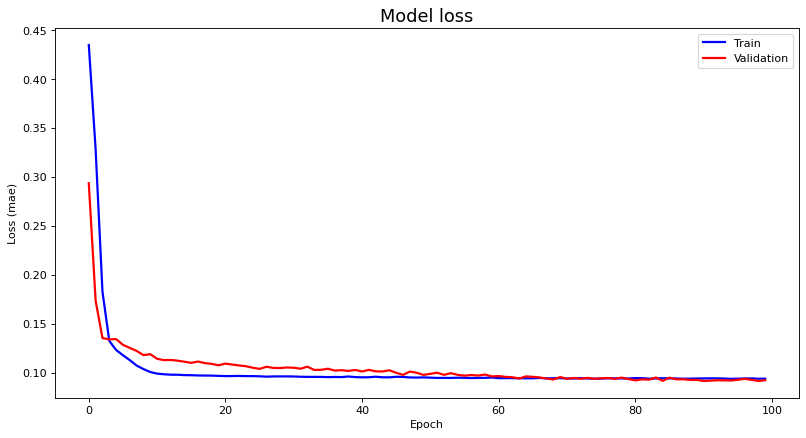

In [99]:

# plot the training losses
fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
Maximum Loss: 0.2518349777091837


/var/folders/5j/2rn0czn97bj7j7qf_hnk1m4r0000gn/T/ipykernel_5850/1800642479.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


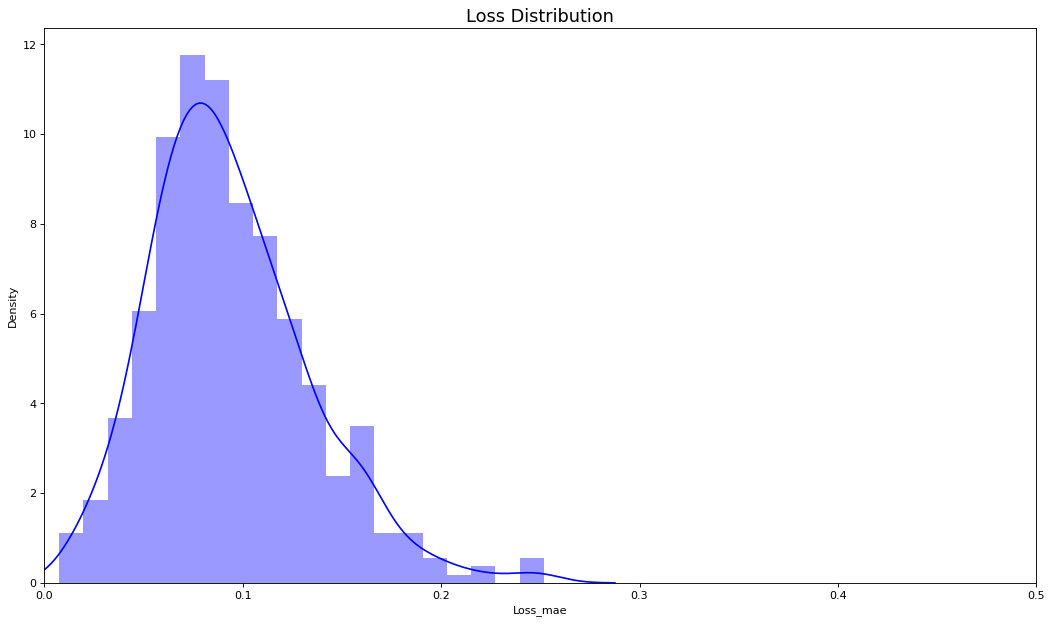

In [113]:

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_data.columns)
X_pred.index = train_data.index

scored = pd.DataFrame(index=train_data.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

max_loss = scored['Loss_mae'].max()
print("Maximum Loss:", max_loss)


In [114]:

# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_data.columns)
X_pred.index = test_data.index

scored = pd.DataFrame(index=test_data.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.2518
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


,Loss_mae,Threshold,Anomaly
Date,,,
2004-02-15 12:52:39,0.087963,0.2518,False
2004-02-15 13:02:39,0.173989,0.2518,False
2004-02-15 13:12:39,0.056138,0.2518,False
2004-02-15 13:22:39,0.064950,0.2518,False
2004-02-15 13:32:39,0.040411,0.2518,False


In [115]:

#Create loss for the training set 
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train_data.columns)
X_pred_train.index = train_data.index

scored_train = pd.DataFrame(index=train_data.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.2518
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

scored

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


,Loss_mae,Threshold,Anomaly
Date,,,
2004-02-12 10:52:39,0.223657,0.2518,False
2004-02-12 11:02:39,0.251835,0.2518,True
2004-02-12 11:12:39,0.136960,0.2518,False
2004-02-12 11:22:39,0.248136,0.2518,False
2004-02-12 11:32:39,0.170929,0.2518,False
...,...,...,...
2004-02-19 05:42:39,31.353973,0.2518,True
2004-02-19 05:52:39,21.969794,0.2518,True
2004-02-19 06:02:39,24.419540,0.2518,True


<Axes: xlabel='Date'>

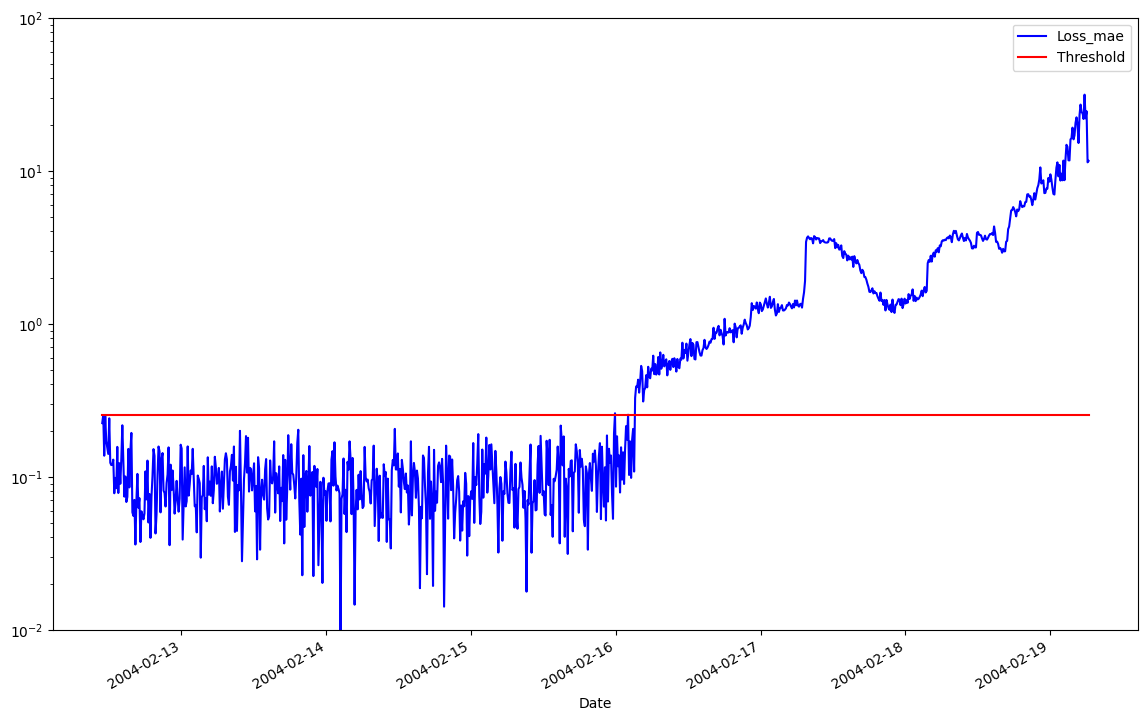

In [116]:
# failure time plot
scored.plot(logy=True,  figsize=(14,9), ylim=[1e-2,1e2], color=['blue','red'])